In [49]:
from __future__ import division
import numpy as np
import os
import glob

from random import *
from PIL import Image
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.image as mpimg
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, ELU, Activation, BatchNormalization
from keras.layers.convolutional import Convolution2D, Cropping2D, ZeroPadding2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD, Adam, RMSprop
from keras.callbacks import ModelCheckpoint

In [1]:
d = {}
from subprocess import check_output
# print(check_output(["ls", "../input"]).decode("utf8"))
# forms = pd.read_csv('../input/iam-handwriting-top50/forms_for_parsing.txt', header=None)
# print(forms.head)
with open('/Users/vishwas/Desktop/build_my_web/data/forms_for_parsing.txt') as f:
    for line in f:
        key = line.split(' ')[0]
        writer = line.split(' ')[1]
        d[key] = writer
print(len(d.keys()))
d

1539


{'a01-000u': '000',
 'a01-000x': '001',
 'a01-003': '002',
 'a01-003u': '000',
 'a01-003x': '003',
 'a01-007': '004',
 'a01-007u': '000',
 'a01-007x': '003',
 'a01-011': '005',
 'a01-011u': '000',
 'a01-011x': '006',
 'a01-014': '007',
 'a01-014u': '000',
 'a01-014x': '008',
 'a01-020': '009',
 'a01-020u': '000',
 'a01-020x': '010',
 'a01-026': '009',
 'a01-026u': '000',
 'a01-026x': '008',
 'a01-030': '005',
 'a01-030u': '000',
 'a01-030x': '010',
 'a01-038': '007',
 'a01-038x': '011',
 'a01-043': '012',
 'a01-043u': '000',
 'a01-043x': '011',
 'a01-049': '012',
 'a01-049u': '000',
 'a01-049x': '000',
 'a01-053': '013',
 'a01-053u': '000',
 'a01-053x': '014',
 'a01-058': '013',
 'a01-058u': '000',
 'a01-058x': '014',
 'a01-063': '013',
 'a01-063u': '000',
 'a01-063x': '015',
 'a01-068u': '000',
 'a01-072u': '000',
 'a01-072x': '001',
 'a01-077': '016',
 'a01-077u': '000',
 'a01-082u': '000',
 'a01-087': '017',
 'a01-087u': '000',
 'a01-091': '016',
 'a01-091u': '000',
 'a01-096u': '00

In [12]:
tmp = []
target_list = []

path_to_files = os.path.join('/Users/vishwas/Desktop/build_my_web/data/data_subset/data_subset', '*')
for filename in sorted(glob.glob(path_to_files)):
#     print(filename)
    tmp.append(filename)
    image_name = filename.split('/')[-1]
    file, ext = os.path.splitext(image_name)
    parts = file.split('-')
    form = parts[0] + '-' + parts[1]
    for key in d:
        if key == form:
            target_list.append(str(d[form]))
import cv2
img_files = np.asarray(tmp)
img_targets = np.asarray(target_list)
print(img_files.shape)
print(img_targets.shape)

(4899,)
(4899,)


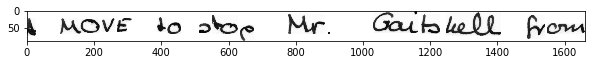

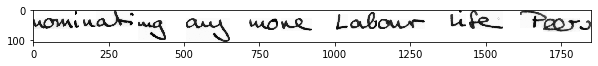

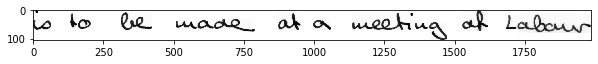

In [13]:
for filename in img_files[:3]:
    img=mpimg.imread(filename)
    plt.figure(figsize=(10,10))
    plt.imshow(img, cmap ='gray')

In [14]:
encoder = LabelEncoder()
encoder.fit(img_targets)
encoded_Y = encoder.transform(img_targets)

print(img_files[:5], img_targets[:5], encoded_Y[:5])

['/Users/vishwas/Desktop/build_my_web/data/data_subset/data_subset/a01-000u-s00-00.png'
 '/Users/vishwas/Desktop/build_my_web/data/data_subset/data_subset/a01-000u-s00-01.png'
 '/Users/vishwas/Desktop/build_my_web/data/data_subset/data_subset/a01-000u-s00-02.png'
 '/Users/vishwas/Desktop/build_my_web/data/data_subset/data_subset/a01-000u-s00-03.png'
 '/Users/vishwas/Desktop/build_my_web/data/data_subset/data_subset/a01-000u-s01-00.png'] ['000' '000' '000' '000' '000'] [0 0 0 0 0]


In [15]:
train_files, rem_files, train_targets, rem_targets = train_test_split(
        img_files, encoded_Y, train_size=0.66, random_state=52, shuffle= True)

validation_files, test_files, validation_targets, test_targets = train_test_split(
        rem_files, rem_targets, train_size=0.5, random_state=22, shuffle=True)

print(train_files.shape, validation_files.shape, test_files.shape)
print(train_targets.shape, validation_targets.shape, test_targets.shape)

(3233,) (833,) (833,)
(3233,) (833,) (833,)


In [45]:
# Generator function for generating random crops from each sentence

# # Now create generators for randomly cropping 113x113 patches from these images

batch_size = 16
num_classes = 50

# Start with train generator shared in the class and add image augmentations
def generate_data(samples, target_files,  batch_size=batch_size, factor = 0.1 ):
    num_samples = len(samples)
    from sklearn.utils import shuffle
    while 1: # Loop forever so the generator never terminates
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            batch_targets = target_files[offset:offset+batch_size]

            images = []
            targets = []
            for i in range(len(batch_samples)):
                batch_sample = batch_samples[i]
                batch_target = batch_targets[i]
                im = Image.open(batch_sample)
                cur_width = im.size[0]
                cur_height = im.size[1]

                # print(cur_width, cur_height)
                height_fac = 113 / cur_height

                new_width = int(cur_width * height_fac)
                size = new_width, 113

                imresize = im.resize((size), Image.ANTIALIAS)  # Resize so height = 113 while keeping aspect ratio
                now_width = imresize.size[0]
                now_height = imresize.size[1]
                # Generate crops of size 113x113 from this resized image and keep random 10% of crops

                avail_x_points = list(range(0, now_width - 113 ))# total x start points are from 0 to width -113

                # Pick random x%
                pick_num = int(len(avail_x_points)*factor)

                # Now pick
                random_startx = sample(avail_x_points,  pick_num)

                for start in random_startx:
                    imcrop = imresize.crop((start, 0, start+113, 113))
                    images.append(np.asarray(imcrop))
                    targets.append(batch_target)

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(targets)

            #reshape X_train for feeding in later
            X_train = X_train.reshape(X_train.shape[0], 113, 113, 1)
            #convert to float and normalize
            X_train = X_train.astype('float32')
            X_train /= 255

            #One hot encode y
            y_train = to_categorical(y_train, num_classes)
            yield shuffle(X_train), shuffle(y_train)

In [46]:
train_generator = generate_data(train_files, train_targets, batch_size=batch_size, factor = 0.3)
validation_generator = generate_data(validation_files, validation_targets, batch_size=batch_size, factor = 0.3)
test_generator = generate_data(test_files, test_targets, batch_size=batch_size, factor = 0.1)
print(next(validation_generator)[1])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [47]:
def resize_image(image):
    import tensorflow as tf
    return tf.image.resize(image,[56,56])

# Function to resize image to 64x64
row, col, ch = 113, 113, 1

model = Sequential()
model.add(ZeroPadding2D((1, 1), input_shape=(row, col, ch)))

# Resise data within the neural network
model.add(Lambda(resize_image))  #resize images to allow for easy computation

# CNN model - Building the model suggested in paper

model.add(Convolution2D(filters= 32, kernel_size =(5,5), strides= (2,2), padding='same', name='conv1')) #96
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), name='pool1'))

model.add(Convolution2D(filters= 64, kernel_size =(3,3), strides= (1,1), padding='same', name='conv2'))  #256
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), name='pool2'))

model.add(Convolution2D(filters= 128, kernel_size =(3,3), strides= (1,1), padding='same', name='conv3'))  #256
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), name='pool3'))


model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(512, name='dense1'))  #1024
# model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(256, name='dense2'))  #1024
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes,name='output'))
model.add(Activation('softmax'))  #softmax since output is within 50 classes

model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_3 (ZeroPaddin (None, 115, 115, 1)       0         
_________________________________________________________________
lambda_3 (Lambda)            (None, 56, 56, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 28, 28, 32)        832       
_________________________________________________________________
activation_6 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 14, 14, 64)        18496     
_________________________________________________________________
activation_7 (Activation)    (None, 14, 14, 64)       

In [54]:
nb_epoch = 1

samples_per_epoch_value = 3
nb_val_samples = 8


#save every model using Keras checkpoint
from keras.callbacks import ModelCheckpoint
filepath="checkpoint2/check-{epoch:02d}-{val_loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath= filepath, verbose=1, save_best_only=False)
callbacks_list = [checkpoint]

#Model fit generator
history_object = model.fit_generator(train_generator, steps_per_epoch= samples_per_epoch_value,
                                     validation_data=validation_generator,
                                     validation_steps=nb_val_samples, epochs=nb_epoch, verbose=1, callbacks=callbacks_list)

3/3 [==============================] - 21s 9s/step - loss: 3.6732 - accuracy: 0.2094 - val_loss: 3.7186 - val_accuracy: 0.1710

Epoch 00001: saving model to checkpoint2/check-01-3.7186.hdf5


In [57]:
model.load_weights('/Users/vishwas/Desktop/build_my_web/checkpoint2/check-01-3.7186.hdf5')
scores = model.evaluate_generator(test_generator,8) 
print("Accuracy = ", scores[1])

Accuracy =  0.2735741138458252


In [60]:
images = []
for filename in test_files[:50]:
    im = Image.open(filename)
    cur_width = im.size[0]
    cur_height = im.size[1]

    # print(cur_width, cur_height)
    height_fac = 113 / cur_height

    new_width = int(cur_width * height_fac)
    size = new_width, 113

    imresize = im.resize((size), Image.ANTIALIAS)  # Resize so height = 113 while keeping aspect ratio
    now_width = imresize.size[0]
    now_height = imresize.size[1]
    # Generate crops of size 113x113 from this resized image and keep random 10% of crops

    avail_x_points = list(range(0, now_width - 113 ))# total x start points are from 0 to width -113

    # Pick random x%
    factor = 0.1
    pick_num = int(len(avail_x_points)*factor)
    
    random_startx = sample(avail_x_points,  pick_num)

    for start in random_startx:
        imcrop = imresize.crop((start, 0, start+113, 113))
        images.append(np.asarray(imcrop))
        
    X_test = np.array(images)
    
    X_test = X_test.reshape(X_test.shape[0], 113, 113, 1)
    #convert to float and normalize
    X_test = X_test.astype('float32')
    X_test /= 255
    shuffle(X_test)

print(X_test.shape)

(6351, 113, 113, 1)


In [64]:
predictions = model.predict(X_test, verbose =1)

print(predictions.shape)
predicted_writer = []
for pred in predictions:
    predicted_writer.append(np.argmax(pred))
print(len(predicted_writer))

199/199 [==============================] - 1s 7ms/step
(6351, 50)
6351


0

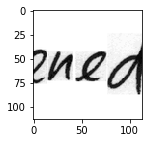

In [83]:
writer_number = 18
total_images =10
counter = 0
for i in range(len(predicted_writer)):
    if predicted_writer[i] == writer_number:
        image = X_test[i].squeeze()
        plt.figure(figsize=(2,2))
        plt.imshow(image, cmap ='gray')
image = X_test[x].squeeze()
plt.figure(figsize=(2,2))
plt.imshow(image, cmap ='gray')
predicted_writer[x]